In [1]:
import numpy as np
import pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env import generate_random_act, MaterialEnvironment, extract_data_from_ep
import collections
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Random policy

In [2]:
# Load Q_data_random
with open('./data/Q_data_random.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_data_random))

Number of episodes generated by random policy: 1000


In [3]:
s_material_inputs = []
s_step_inputs     = []
a_elem_inputs     = []
a_comp_inputs     = []
Q_targets         = []

for episode in Q_data_random:
    for step in episode:
        # state, action, reward = step
        [s_material, s_step], [a_elem, a_comp], Q_target = step

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)

s_material_inputs = torch.stack(s_material_inputs)
s_step_inputs = torch.stack(s_step_inputs)
a_elem_inputs = torch.stack(a_elem_inputs)
a_comp_inputs = torch.stack(a_comp_inputs)
Q_targets = torch.stack(Q_targets)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('')

s_material_inputs: torch.Size([5000, 145])
s_step_inputs: torch.Size([5000, 5])
a_elem_inputs: torch.Size([5000, 80])
a_comp_inputs: torch.Size([5000, 10])
Q_targets: torch.Size([5000, 1])



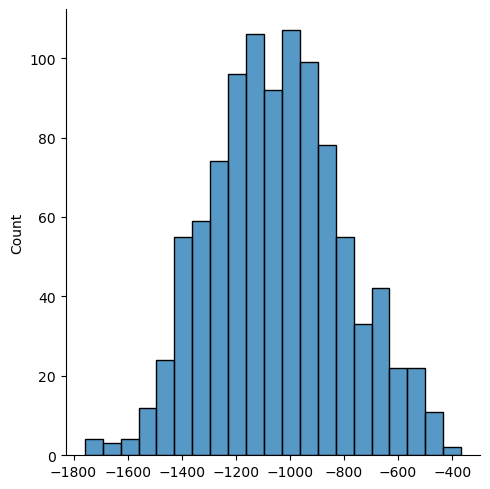

In [4]:
# Plot distribution of final rewards by random policy
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.displot(final_rewards_random)
plt.show()

# Training Q-network with random policy data

In [5]:
# sample_size = 5000
# s_material_inputs = s_material_inputs[:sample_size,:]
# s_step_inputs = s_step_inputs[:sample_size,:]
# a_elem_inputs = a_elem_inputs[:sample_size,:]
# a_comp_inputs = a_comp_inputs[:sample_size,:]
# Q_targets = Q_targets[:sample_size,:]
# print('s_material_inputs:', s_material_inputs.shape)
# print('s_step_inputs:', s_step_inputs.shape)
# print('a_elem_inputs:', a_elem_inputs.shape)
# print('a_comp_inputs:', a_comp_inputs.shape)
# print('Q_targets:', Q_targets.shape)

In [6]:
# Initialize Q network
dqn = DQN_pytorch()

# Train Q network
optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
loss_func = torch.nn.SmoothL1Loss().float()

start = time.time()
for epoch in range(100):
    prediction = dqn(s_material = s_material_inputs, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_inputs,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_inputs,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_inputs,  # torch.Size([batch_size,10])
                    )                    # Input x and predict based on x
    loss       = loss_func(prediction.float(), Q_targets.float()).float()   # Must be (1. nn output, 2. target)
    optimizer.zero_grad()   # Clear gradients for next train
    loss.backward()         # Backpropagation, compute gradients
    optimizer.step()        # Apply gradients
    print('Epoch = ', epoch, 'Loss = %.4f' % loss.data.numpy())
end = time.time()
print('time taken for batch:', end - start)

Epoch =  0 Loss = 845.8337
Epoch =  1 Loss = 708.2661
Epoch =  2 Loss = 502.3942
Epoch =  3 Loss = 415.2260
Epoch =  4 Loss = 509.8362
Epoch =  5 Loss = 428.3345
Epoch =  6 Loss = 380.2577
Epoch =  7 Loss = 406.3513
Epoch =  8 Loss = 421.4671
Epoch =  9 Loss = 403.9472
Epoch =  10 Loss = 370.3942
Epoch =  11 Loss = 355.5617
Epoch =  12 Loss = 370.7014
Epoch =  13 Loss = 374.1996
Epoch =  14 Loss = 349.5461
Epoch =  15 Loss = 328.7539
Epoch =  16 Loss = 328.4388
Epoch =  17 Loss = 327.3794
Epoch =  18 Loss = 313.6695
Epoch =  19 Loss = 306.3153
Epoch =  20 Loss = 312.0566
Epoch =  21 Loss = 303.2613
Epoch =  22 Loss = 297.8599
Epoch =  23 Loss = 303.3957
Epoch =  24 Loss = 297.0670
Epoch =  25 Loss = 294.1990
Epoch =  26 Loss = 298.8301
Epoch =  27 Loss = 293.5767
Epoch =  28 Loss = 291.2238
Epoch =  29 Loss = 293.5618
Epoch =  30 Loss = 289.9482
Epoch =  31 Loss = 286.1857
Epoch =  32 Loss = 287.0447
Epoch =  33 Loss = 284.5121
Epoch =  34 Loss = 280.5435
Epoch =  35 Loss = 279.9263
Ep

In [7]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set)):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    1st index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).float() # Get one-hot rep of s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    s_material_input = torch.stack([s_material]*n_actions)
    s_step_input = torch.stack([s_step]*n_actions)

    a_elem_input = []
    a_comp_input = []
    for elem in element_set:
        a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
        for comp in comp_set:
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float()
    a_comp_input = torch.stack(a_comp_input).float()
    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.detach().numpy()
    Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(element_set)])
    a_comp_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(comp_set)])
    Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))

    for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (len(element_set)*len(comp_set) - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print(Q_pred_ranked.shape)
    # print(a_elem_input_ranked.shape)
    # print(a_comp_input_ranked.shape)
    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Based on {}:'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn)
print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
print('')

print('Based on {}:'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn)
print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Based on BaTiO3:
max_a_elem:  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
max_a_comp:  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

Based on SrTiO3:
max_a_elem:  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
max_a_comp:  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


In [8]:
# Investigate weights of dqn
dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),

(tensor(0.0111, grad_fn=<MeanBackward0>),
 tensor(0.2696, grad_fn=<MeanBackward0>),
 tensor(0.4209, grad_fn=<MeanBackward0>),
 tensor(0.4852, grad_fn=<MeanBackward0>))

In [9]:
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(featurize_target('BaTiO3'))
s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0])
# print(s_step.shape)

a_elem = torch.zeros(80)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0])
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0])
# print(a_comp.shape)

output = dqn(s_material, s_step, a_elem, a_comp)
print(output)
# print(output.shape)

tensor([[-988.4760]], grad_fn=<AddmmBackward>)


In [10]:
env = MaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn(dqn, max_steps = 5, epsilon = 0, stochastic_top_frac = 0):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    
    '''
    env.initialize()

    for i in range(max_steps):
        # if i == 0: # if start of episode, choose random first element #########################
        #     action = generate_random_act()

        # else: # elif not start of episode, take greedy action
        #     # Max action
        #     action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn)
        if np.random.uniform(0,1) > epsilon:
            action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn, stochastic_top_frac = stochastic_top_frac)
        else:
            action = generate_random_act()
        # Take step with action
        env.step(action)
        print('step:', env.counter)
        print('state:',env.state)
        print('reward:',env.reward())
        # print(env.num_steps_taken)
        print('')
    return env.path
generate_ep_with_dqn(dqn = dqn)

step: 1
state: B1
reward: 0

step: 2
state: B1B1
reward: 0

step: 3
state: B1B1B1
reward: 0

step: 4
state: B1B1B1B1
reward: 0

step: 5
state: B1B1B1B1B1
reward: -913.173



[([[0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,

In [11]:
# ========= FOR TRAINED POLICY ===========
start = time.time()
#Generate episodes with DQN
num_eps = 300
episodes = []
for j in range(num_eps):
    episode = generate_ep_with_dqn(dqn, max_steps = 5, epsilon = 0, stochastic_top_frac = 0.05)
    episodes.append(episode)

Q_data_trained = []
# Extract Q_data from episodes
for episode in episodes:
    Q_data = extract_data_from_ep(episode)
    Q_data_trained.append(Q_data)
end = time.time()
print('time taken:', end - start)

# Save Q_data
with open('./data/Q_data_trained.pkl', 'wb') as f:
    pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

step: 1
state: Li1
reward: 0

step: 2
state: Li1B2
reward: 0

step: 3
state: Li1B2Se7
reward: 0

step: 4
state: Li1B2Se7Cl3
reward: 0

step: 5
state: Li1B2Se7Cl3
reward: -372.0303

step: 1
state: Se1
reward: 0

step: 2
state: Se1Se6
reward: 0

step: 3
state: Se1Se6Li9
reward: 0

step: 4
state: Se1Se6Li9Pb1
reward: 0

step: 5
state: Se1Se6Li9Pb1Cl1
reward: -434.7162

step: 1
state: Li1
reward: 0

step: 2
state: Li1B7
reward: 0

step: 3
state: Li1B7Se2
reward: 0

step: 4
state: Li1B7Se2Li8
reward: 0

step: 5
state: Li1B7Se2Li8Pb1
reward: -439.887

step: 1
state: B6
reward: 0

step: 2
state: B6Se8
reward: 0

step: 3
state: B6Se8Cl1
reward: 0

step: 4
state: B6Se8Cl1Cs1
reward: 0

step: 5
state: B6Se8Cl1Cs1B1
reward: -431.34845

step: 1
state: Li6
reward: 0

step: 2
state: Li6B6
reward: 0

step: 3
state: Li6B6B8
reward: 0

step: 4
state: Li6B6B8
reward: 0

step: 5
state: Li6B6B8V2
reward: -409.974

step: 1
state: B1
reward: 0

step: 2
state: B1Cs1
reward: 0

step: 3
state: B1Cs1Li7
reward:

In [12]:
# Load Q_data_random
with open('./data/Q_data_trained.pkl', 'rb') as f:
    Q_data_trained = pickle.load(f)

print('Number of episodes generated by agent trained on random policy data:',len(Q_data_trained))

Q_targets_trained         = []

for episode in Q_data_trained:
    for step in episode:
        # state, action, reward = step
        _, _, Q_target = step
        Q_target = torch.tensor([Q_target])
        Q_targets_trained.append(Q_target)

Q_targets_trained = torch.stack(Q_targets_trained)
print('Q_targets:', Q_targets_trained.shape)

Number of episodes generated by agent trained on random policy data: 300
Q_targets: torch.Size([1500, 1])


/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


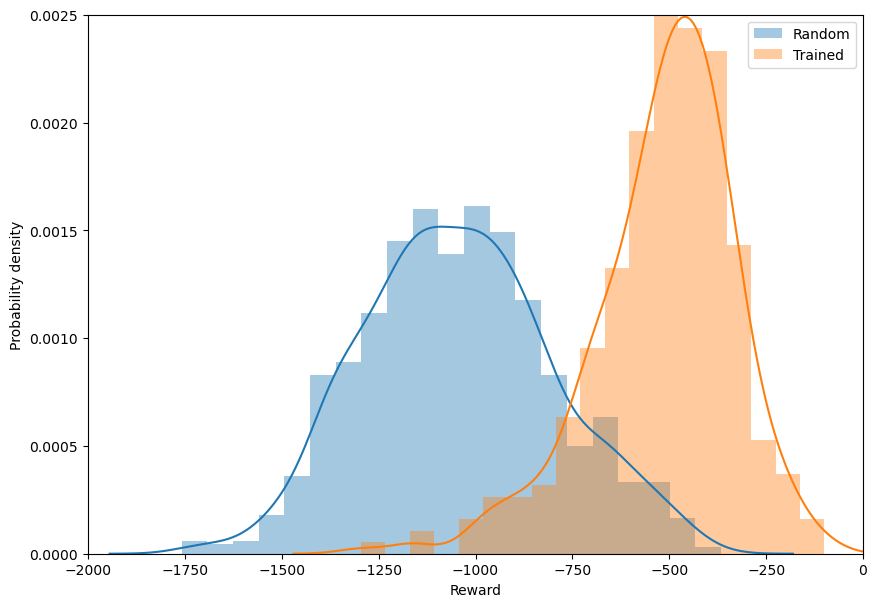

In [13]:
# Plot distribution of final rewards by random vs trained policy
final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # find final rewards
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
plt.ylabel('Probability density')
plt.xlabel('Reward')
plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
plt.savefig(fname = 'plots/reward_dist.png')
plt.show()

# Closing the RL loop

In [14]:
num_iter = 1000 # No. of training iterations
epsilon  = 0.99   # Initial epsilon
replay_buffer = collections.deque(max_len = 50000)

for iteration in range(num_iter):
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
    print('Current epsilon = ', epsilon)

    # Initialize env
    env = MaterialEnvironment(element_set = element_set,
                              comp_set =  comp_set,)
    



TypeError: 'max_len' is an invalid keyword argument for deque()